# 13.1 Sparse coding (Olshausen & Field, 1996) モデル
視覚におけるSparse codingのモデル ([Olshausen & Field, *Nature*. 1996](https://www.nature.com/articles/381607a0))の実装を目標とする。

```{note}
Sparse codingをどこに入れるかは迷ったが、生成モデルではあるのでこの章に入れた。
```

## 13.1.1 画像のsparse coding

画像 $\boldsymbol{I} (\boldsymbol{x})$が基底関数(basis function) $\Phi = [\phi_i(\boldsymbol{x})]$ の線形和で表されるとする。

$$
\boldsymbol{I}(\boldsymbol{x}) = \sum_i r_i \phi_i (\boldsymbol{x}) + \epsilon(\boldsymbol{x})= \Phi \boldsymbol{r} + \epsilon(\boldsymbol{x})
$$

ただし、$\boldsymbol{x}$は画像上の座標, $\epsilon$は平均0のGaussianノイズを表す。また、$\boldsymbol{r}$は係数であるが、モデルにおいては入力よりも高次の神経細胞の活動とみなす。この場合、$\Phi$は重み行列となる。

Sparse codingは、少数の基底で画像 (や目的変数)を表すことを目的とする。要は(1)式において、ほとんどが0で、一部だけ0以外の値を取るという疎 (=sparse)な係数$\boldsymbol{r}$を求めたい。

## 13.1.2 目的関数の設定
Sparse codingのための目的関数(cost function) $E$は(2)式のようになる。

$$
E = \underbrace{\left\|\boldsymbol{I}-\Phi \boldsymbol{r}\right\|^2}_{\text{preserve information}} + \lambda \underbrace{\sum_i S\left(\frac{r_i}{\sigma}\right)}_{\text{sparseness of}\ r_i}
$$

ただし、$\lambda$は正則化係数、$\sigma$は定数(scaling constant)である。ここで、第一項が復元損失、第二項が罰則項 (係数が大きな値とならないようにする項)となっている。

$S(x)$としては $-\exp(-x^2), \ln(1+x^2), |x|$ などの関数が用いられる。これらの関数は原点において尖った形状をしており、解が0になりやすくなっている。

##  13.1.3 Locally Competitive Algorithm (LCA) 
$\boldsymbol{r}$の勾配法による更新則は、目的関数 $E$の微分により次のように得られる。

$$
\begin{align}
\frac{d \boldsymbol{r}}{dt} &= -\frac{\eta_\boldsymbol{r}}{2}\frac{\partial E}{\partial \boldsymbol{r}}\\
&=\eta_\boldsymbol{r} \cdot\left[\Phi^T (\boldsymbol{I}-\Phi\boldsymbol{r})- \frac{\lambda}{2\sigma}S'\left(\frac{r_i}{\sigma}\right)\right]
\end{align}
$$

ただし、$\eta_{\boldsymbol{r}}$は学習率である。この式により$\boldsymbol{r}$が収束するまで最適化するが、単なる勾配法ではなく、(Olshausen & Field, 1996)では**共役勾配法** (conjugate gradient method)を用いている。しかし、共役勾配法は実装が煩雑で非効率であるため、より効率的かつ生理学的な妥当性の高い学習法として、**LCA**  (locally competitive algorithm)が提案されている ([Rozell et al., *Neural Comput*. 2008](https://www.ece.rice.edu/~eld1/papers/Rozell08.pdf))。LCAは**側抑制** (local competition, lateral inhibition)と**閾値関数** (thresholding function)を用いる更新則である。LCAによる更新を行うRNNは通常のRNNとは異なり、コスト関数(またはエネルギー関数)を最小化する動的システムである。このような機構はHopfield networkで用いられているために、Olshausenは**Hopfield trick**と呼んでいる。

### 軟判定閾値関数を用いる場合 (ISTA)
$S(x)=|x|$とした場合の閾値関数を用いる手法として**ISTA**(Iterative Shrinkage Thresholding Algorithm)がある。ISTAはL1-norm正則化項に対する近接勾配法で、要はLasso回帰に用いる勾配法である。

解くべき問題は次式で表される。

$$
\boldsymbol{r} = \mathop{\rm arg~min}\limits_{\boldsymbol{r}}\left\{\|\boldsymbol{I}-\Phi\boldsymbol{r}\|^2_2+\lambda\|\boldsymbol{r}\|_1\right\}
$$

詳細は後述するが、次のように更新することで解が得られる。

1. $\boldsymbol{r}(0)$を要素が全て0のベクトルで初期化
2. $\boldsymbol{r}_*(t+1)=\boldsymbol{r}(t)+\eta_\boldsymbol{r}\cdot \Phi^T(\boldsymbol{I}-\Phi\boldsymbol{r}(t))$
3. $\boldsymbol{r}(t+1) = S_\lambda(\boldsymbol{r}_*(t+1))$
4. $\boldsymbol{r}$が収束するまで2と3を繰り返す

ここで$S_\lambda(\cdot)$は**軟判定閾値関数** (Soft thresholding function)と呼ばれ、次式で表される。

$$
S_\lambda(y)= 
\begin{cases} 
y-\lambda & (y>\lambda)\\ 
0 & (-\lambda\leq y\leq\lambda)\\ 
 y+\lambda & (y<-\lambda) 
\end{cases}
$$

$S_\lambda(\cdot)$を関数として定義すると次のようになる。

In [1]:
# thresholding function of S(x)=|x|
function soft_thresholding_func(x, lmda)
    max(x - lmda, 0) - max(-x - lmda, 0)
end

soft_thresholding_func (generic function with 1 method)

次に$S_\lambda(\cdot)$を描画すると次のようになる。ただし、先に`PyPlot`を読み込んでおく。

In [2]:
using PyPlot

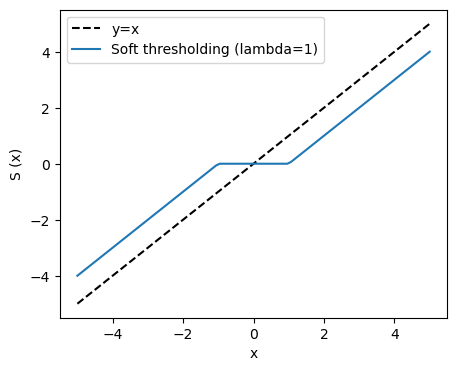

PyObject <matplotlib.legend.Legend object at 0x000000003EF1CF08>

In [3]:
x = range(-5, 5, length=100)
y = soft_thresholding_func.(x, 1)


figure(figsize=(5,4))
plot(x, x, "k--", label="y=x")
plot(x, y, label="Soft thresholding (lambda=1)")
xlabel("x")
ylabel("S (x)")
legend()

なお、Soft thresholding関数は次の目的関数$C$を最小化する$x$を求めることで導出できる。

$$
C=\frac{1}{2}(y-x)^2+\lambda |x|
$$

ただし、$x, y, \lambda$はスカラー値とする。$|x|$が微分できないが、これは場合分けを考えることで解決する。$x\geq 0$を考えると、(6)式は

$$
C=\frac{1}{2}(y-x)^2+\lambda x = \{x-(y-\lambda)\}^2+\lambda(y-\lambda)
$$

となる。(7)式の最小値を与える$x$は場合分けをして考えると、$y-\lambda\geq0$のとき二次関数の頂点を考えて$x=y-\lambda$となる。 一方で$y-\lambda<0$のときは$x\geq0$において単調増加な関数となるので、最小となるのは$x=0$のときである。同様の議論を$x\leq0$に対しても行うことで (5)式が得られる。

## 13.1.4 重み行列の更新則
$\boldsymbol{r}$が収束したら勾配法により$\Phi$を更新する。

$$
\begin{aligned}
\Delta \phi_i(\boldsymbol{x}) &= -\eta \frac{\partial E}{\partial \Phi}\\
&=\eta\cdot\left[\left([\boldsymbol{I}-\Phi\boldsymbol{r}\right)\boldsymbol{r}^T\right]
\end{aligned}
$$

## 13.1.5 Sparse coding networkの実装
ネットワークは入力層を含め2層の単純な構造である。今回は、入力はランダムに切り出した16×16 (＝256)の画像パッチとし、これを入力層の256個のニューロンが受け取るとする。入力層のニューロンは次層の100個のニューロンに投射するとする。100個のニューロンが入力をSparseに符号化するようにその活動および重み行列を最適化する。

### 画像データの読み込み
データは<http://www.rctn.org/bruno/sparsenet/>からダウンロードできる。`IMAGES_RAW.mat`は10枚の自然画像で、`IMAGES.mat`はそれを白色化したものである。`mat`ファイルの読み込みには[MAT.jl](https://github.com/JuliaIO/MAT.jl)を用いる。

In [4]:
using MAT

In [5]:
# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images_raw = matopen("_static/datasets/IMAGES_RAW.mat")
imgs_raw = read(mat_images_raw, "IMAGESr")

mat_images = matopen("_static/datasets/IMAGES.mat")
imgs = read(mat_images, "IMAGES")

close(mat_images_raw)
close(mat_images)

画像データを描画する。

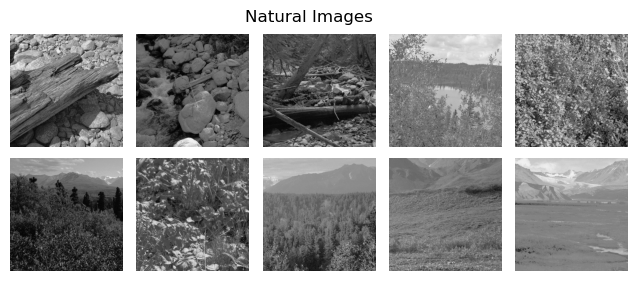

In [6]:
figure(figsize=(8, 3))
subplots_adjust(hspace=0.1, wspace=0.1)
for i=1:10
    subplot(2, 5, i)
    imshow(imgs_raw[:,:,i], cmap="gray")
    axis("off")
end
suptitle("Natural Images", fontsize=12)
subplots_adjust(top=0.9)  

### モデルの定義
必要なパッケージを読み込む。

In [7]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra
using Random
using Statistics
using ProgressMeter

モデルを定義する。

In [8]:
@kwdef struct OFParameter{FT}
    lr_r::FT = 1e-2 # learning rate of r
    lr_Phi::FT = 1e-2 # learning rate of Phi
    lmda::FT = 5e-3 # regularization parameter
end

@kwdef mutable struct OlshausenField1996Model{FT}
    param::OFParameter = OFParameter{FT}()
    num_inputs::Int32
    num_units::Int32
    batch_size::Int32
    r::Array{FT} = zeros(batch_size, num_units) # activity of neurons
    Phi::Array{FT} = randn(num_inputs, num_units) .* sqrt(1/num_units)
end

パラメータを更新する関数を定義する。

In [9]:
function updateOF!(variable::OlshausenField1996Model, param::OFParameter, inputs::Array, training::Bool)
    @unpack num_inputs, num_units, batch_size, r, Phi = variable
    @unpack lr_r, lr_Phi, lmda = param

    # Updates                
    error = inputs .- r * Phi'
    r_ = r +lr_r .* error * Phi

    r[:, :] = soft_thresholding_func.(r_, lmda)

    if training 
        error = inputs - r * Phi'
        dPhi = error' * r
        Phi[:, :] += lr_Phi * dPhi
    end
    
    return error
end

updateOF! (generic function with 1 method)

行ごとに正規化する関数を定義する。

In [10]:
function normalize_rows(A::Array)
    return A ./ sqrt.(sum(A.^2, dims=1) .+ 1e-8)
end

normalize_rows (generic function with 1 method)

損失関数を定義する。

In [11]:
function calculate_total_error(error, r, lmda)
    recon_error = mean(error.^2)
    sparsity_r = lmda*mean(abs.(r)) 
    return recon_error + sparsity_r
end

calculate_total_error (generic function with 1 method)

シミュレーションを実行する関数を定義する。外側の`for loop`では画像パッチの作成と`r`の初期化を行う。内側の`for loop`では`r`が収束するまで更新を行い、収束したときに重み行列`Phi`を更新する。

In [12]:
function run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)
    H, W, num_images = size(imgs)
    num_inputs = sz^2

    model = OlshausenField1996Model{Float32}(num_inputs=num_inputs, num_units=num_units, batch_size=batch_size)
    errorarr = zeros(num_iter) # Vector to save errors    
    
    # Run simulation
    @showprogress "Computing..." for iter in 1:num_iter
        # Get the coordinates of the upper left corner of clopping image randomly.
        beginx = rand(1:W-sz, batch_size)
        beginy = rand(1:H-sz, batch_size)

        inputs = zeros(batch_size, num_inputs)  # Input image patches

        # Get images randomly
        for i in 1:batch_size        
            idx = rand(1:num_images)
            img = imgs[:, :, idx]
            clop = img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1][:]
            #clop = collect(flatten(img[beginy[i]:beginy[i]+sz-1, beginx[i]:beginx[i]+sz-1]))
            inputs[i, :] = clop .- mean(clop)
        end

        model.r = zeros(batch_size, num_units) # Reset r states
        model.Phi = normalize_rows(model.Phi) # Normalize weights
        # Input image patches until latent variables are converged 
        r_tm1 = zeros(batch_size, num_units)  # set previous r (t minus 1)

        for t in 1:nt_max
            # Update r without update weights 
            error = updateOF!(model, model.param, inputs, false)

            dr = model.r - r_tm1 

            # Compute norm of r
            dr_norm = sqrt(sum(dr.^2)) / sqrt(sum(r_tm1.^2) + 1e-8)
            r_tm1 = copy(model.r) # update r_tm1

            # Check convergence of r, then update weights
            if dr_norm < eps
                error = updateOF!(model, model.param, inputs, true)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end

            # If failure to convergence, break and print error
            if t >= nt_max-1
                print("Error at patch:", iter_, dr_norm)
                errorarr[iter] = calculate_total_error(error, model.r, model.param.lmda) # Append errors
                break
            end
        end
        """
        # Print moving average error
        if iter % 100 == 0
            moving_average_error = mean(errorarr[iter-99:iter])
            println("iter: ", iter, "/", num_iter, ", Moving average error:", moving_average_error)
        end
        """
    end
    return model, errorarr
end

run_simulation (generic function with 1 method)

### シミュレーションの実行

In [13]:
# Simulation constants
num_iter = 500 # number of iterations
nt_max = 1000 # Maximum number of simulation time
batch_size = 250 # Batch size

sz = 16 # image patch size
num_units = 100 # number of neurons (units)
eps = 1e-2 # small value which determines convergence

model, errorarr = run_simulation(imgs, num_iter, nt_max, batch_size, sz, num_units, eps)

Computing...  0%|█                                      |  ETA: 0:18:01

Computing...  0%|█                                      |  ETA: 0:10:49

Computing...  1%|█                                      |  ETA: 0:08:00

Computing...  1%|█                                      |  ETA: 0:06:36

Computing...  1%|█                                      |  ETA: 0:05:46

Computing...  1%|█                                      |  ETA: 0:05:12

Computing...  1%|█                                      |  ETA: 0:04:48

Computing...  2%|█                                      |  ETA: 0:04:29

Computing...  2%|█                                      |  ETA: 0:04:15

Computing...  2%|█                                      |  ETA: 0:04:03

Computing...  2%|█                                      |  ETA: 0:03:53

Computing...  2%|█                                      |  ETA: 0:03:45

Computing...  3%|██                                     |  ETA: 0:03:38

Computing...  3%|██                                     |  ETA: 0:03:33

Computing...  3%|██                                     |  ETA: 0:03:28

Computing...  3%|██                                     |  ETA: 0:03:23

Computing...  3%|██                                     |  ETA: 0:03:19

Computing...  4%|██                                     |  ETA: 0:03:15

Computing...  4%|██                                     |  ETA: 0:03:12

Computing...  4%|██                                     |  ETA: 0:03:09

Computing...  4%|██                                     |  ETA: 0:03:06

Computing...  4%|██                                     |  ETA: 0:03:03

Computing...  5%|██                                     |  ETA: 0:03:01

Computing...  5%|██                                     |  ETA: 0:02:59

Computing...  5%|██                                     |  ETA: 0:02:56

Computing...  5%|███                                    |  ETA: 0:02:54

Computing...  5%|███                                    |  ETA: 0:02:53

Computing...  6%|███                                    |  ETA: 0:02:51

Computing...  6%|███                                    |  ETA: 0:02:49

Computing...  6%|███                                    |  ETA: 0:02:47

Computing...  6%|███                                    |  ETA: 0:02:46

Computing...  6%|███                                    |  ETA: 0:02:44

Computing...  7%|███                                    |  ETA: 0:02:43

Computing...  7%|███                                    |  ETA: 0:02:41

Computing...  7%|███                                    |  ETA: 0:02:40

Computing...  7%|███                                    |  ETA: 0:02:39

Computing...  7%|███                                    |  ETA: 0:02:37

Computing...  8%|███                                    |  ETA: 0:02:36

Computing...  8%|████                                   |  ETA: 0:02:35

Computing...  8%|████                                   |  ETA: 0:02:34

Computing...  8%|████                                   |  ETA: 0:02:33

Computing...  8%|████                                   |  ETA: 0:02:32

Computing...  9%|████                                   |  ETA: 0:02:31

Computing...  9%|████                                   |  ETA: 0:02:30

Computing...  9%|████                                   |  ETA: 0:02:29

Computing...  9%|████                                   |  ETA: 0:02:28

Computing...  9%|████                                   |  ETA: 0:02:27

Computing... 10%|████                                   |  ETA: 0:02:26

Computing... 10%|████                                   |  ETA: 0:02:25

Computing... 10%|████                                   |  ETA: 0:02:24

Computing... 10%|████                                   |  ETA: 0:02:23

Computing... 10%|█████                                  |  ETA: 0:02:23

Computing... 11%|█████                                  |  ETA: 0:02:22

Computing... 11%|█████                                  |  ETA: 0:02:21

Computing... 11%|█████                                  |  ETA: 0:02:21

Computing... 11%|█████                                  |  ETA: 0:02:20

Computing... 11%|█████                                  |  ETA: 0:02:19

Computing... 12%|█████                                  |  ETA: 0:02:18

Computing... 12%|█████                                  |  ETA: 0:02:18

Computing... 12%|█████                                  |  ETA: 0:02:17

Computing... 12%|█████                                  |  ETA: 0:02:16

Computing... 12%|█████                                  |  ETA: 0:02:16

Computing... 13%|█████                                  |  ETA: 0:02:15

Computing... 13%|█████                                  |  ETA: 0:02:14

Computing... 13%|██████                                 |  ETA: 0:02:14

Computing... 13%|██████                                 |  ETA: 0:02:14

Computing... 13%|██████                                 |  ETA: 0:02:13

Computing... 14%|██████                                 |  ETA: 0:02:13

Computing... 14%|██████                                 |  ETA: 0:02:12

Computing... 14%|██████                                 |  ETA: 0:02:11

Computing... 14%|██████                                 |  ETA: 0:02:11

Computing... 14%|██████                                 |  ETA: 0:02:10

Computing... 15%|██████                                 |  ETA: 0:02:09

Computing... 15%|██████                                 |  ETA: 0:02:09

Computing... 15%|██████                                 |  ETA: 0:02:08

Computing... 15%|██████                                 |  ETA: 0:02:08

Computing... 15%|███████                                |  ETA: 0:02:07

Computing... 16%|███████                                |  ETA: 0:02:07

Computing... 16%|███████                                |  ETA: 0:02:06

Computing... 16%|███████                                |  ETA: 0:02:06

Computing... 16%|███████                                |  ETA: 0:02:05

Computing... 16%|███████                                |  ETA: 0:02:05

Computing... 17%|███████                                |  ETA: 0:02:04

Computing... 17%|███████                                |  ETA: 0:02:04

Computing... 17%|███████                                |  ETA: 0:02:03

Computing... 17%|███████                                |  ETA: 0:02:03

Computing... 17%|███████                                |  ETA: 0:02:02

Computing... 18%|███████                                |  ETA: 0:02:02

Computing... 18%|███████                                |  ETA: 0:02:01

Computing... 18%|████████                               |  ETA: 0:02:01

Computing... 18%|████████                               |  ETA: 0:02:01

Computing... 18%|████████                               |  ETA: 0:02:00

Computing... 19%|████████                               |  ETA: 0:02:00

Computing... 19%|████████                               |  ETA: 0:01:59

Computing... 19%|████████                               |  ETA: 0:01:59

Computing... 19%|████████                               |  ETA: 0:01:58

Computing... 19%|████████                               |  ETA: 0:01:58[39

Computing... 20%|████████                               |  ETA: 0:01:58

Computing... 20%|████████                               |  ETA: 0:01:57

Computing... 20%|████████                               |  ETA: 0:01:57

Computing... 20%|████████                               |  ETA: 0:01:56

Computing... 20%|████████                               |  ETA: 0:01:56

Computing... 21%|█████████                              |  ETA: 0:01:56

Computing... 21%|█████████                              |  ETA: 0:01:55

Computing... 21%|█████████                              |  ETA: 0:01:55

Computing... 21%|█████████                              |  ETA: 0:01:54

Computing... 21%|█████████                              |  ETA: 0:01:54

Computing... 22%|█████████                              |  ETA: 0:01:54

Computing... 22%|█████████                              |  ETA: 0:01:53

Computing... 22%|█████████                              |  ETA: 0:01:53

Computing... 22%|█████████                              |  ETA: 0:01:53

Computing... 22%|█████████                              |  ETA: 0:01:52

Computing... 23%|█████████                              |  ETA: 0:01:52

Computing... 23%|█████████                              |  ETA: 0:01:51

Computing... 23%|█████████                              |  ETA: 0:01:51

Computing... 23%|██████████                             |  ETA: 0:01:51

Computing... 23%|██████████                             |  ETA: 0:01:50

Computing... 24%|██████████                             |  ETA: 0:01:50

Computing... 24%|██████████                             |  ETA: 0:01:50

Computing... 24%|██████████                             |  ETA: 0:01:49

Computing... 24%|██████████                             |  ETA: 0:01:49

Computing... 24%|██████████                             |  ETA: 0:01:49

Computing... 25%|██████████                             |  ETA: 0:01:48

Computing... 25%|██████████                             |  ETA: 0:01:48

Computing... 25%|██████████                             |  ETA: 0:01:47[39

m

Computing... 25%|██████████                             |  ETA: 0:01:47

Computing... 25%|██████████                             |  ETA: 0:01:47

Computing... 26%|██████████                             |  ETA: 0:01:46

Computing... 26%|███████████                            |  ETA: 0:01:46

Computing... 26%|███████████                            |  ETA: 0:01:46

Computing... 26%|███████████                            |  ETA: 0:01:45

Computing... 26%|███████████                            |  ETA: 0:01:45

Computing... 27%|███████████                            |  ETA: 0:01:45

Computing... 27%|███████████                            |  ETA: 0:01:44

Computing... 27%|███████████                            |  ETA: 0:01:44

Computing... 27%|███████████                            |  ETA: 0:01:44

Computing... 27%|███████████                            |  ETA: 0:01:43

Computing... 28%|███████████                            |  ETA: 0:01:43

Computing... 28%|███████████                            |  ETA: 0:01:43

Computing... 28%|███████████                            |  ETA: 0:01:42

Computing... 28%|███████████                            |  ETA: 0:01:42

Computing... 28%|████████████                           |  ETA: 0:01:42

Computing... 29%|████████████                           |  ETA: 0:01:41

Computing... 29%|████████████                           |  ETA: 0:01:41

Computing... 29%|████████████                           |  ETA: 0:01:41

Computing... 29%|████████████                           |  ETA: 0:01:40

Computing... 29%|████████████                           |  ETA: 0:01:40

Computing... 30%|████████████                           |  ETA: 0:01:40

Computing... 30%|████████████                           |  ETA: 0:01:39

Computing... 30%|████████████                           |  ETA: 0:01:39

Computing... 30%|████████████                           |  ETA: 0:01:39

Computing... 30%|████████████                           |  ETA: 0:01:38

Computing... 31%|████████████                           |  ETA: 0:01:38

Computing... 31%|█████████████                          |  ETA: 0:01:38

Computing... 31%|█████████████                          |  ETA: 0:01:37

Computing... 31%|█████████████                          |  ETA: 0:01:37

Computing... 31%|█████████████                          |  ETA: 0:01:37

Computing... 32%|█████████████                          |  ETA: 0:01:36

Computing... 32%|█████████████                          |  ETA: 0:01:36

Computing... 32%|█████████████                          |  ETA: 0:01:36

Computing... 32%|█████████████                          |  ETA: 0:01:35

Computing... 32%|█████████████                          |  ETA: 0:01:35

Computing... 33%|█████████████                          |  ETA: 0:01:35

Computing... 33%|█████████████                          |  ETA: 0:01:34

Computing... 33%|█████████████                          |  ETA: 0:01:34

Computing... 33%|█████████████                          |  ETA: 0:01:34

Computing... 33%|██████████████                         |  ETA: 0:01:33

Computing... 34%|██████████████                         |  ETA: 0:01:33

Computing... 34%|██████████████                         |  ETA: 0:01:33

Computing... 34%|██████████████                         |  ETA: 0:01:32

Computing... 34%|██████████████                         |  ETA: 0:01:32

Computing... 34%|██████████████                         |  ETA: 0:01:32

Computing... 35%|██████████████                         |  ETA: 0:01:32

Computing... 35%|██████████████                         |  ETA: 0:01:31

Computing... 35%|██████████████                         |  ETA: 0:01:31

Computing... 35%|██████████████                         |  ETA: 0:01:31

Computing... 35%|██████████████                         |  ETA: 0:01:30

Computing... 36%|██████████████                         |  ETA: 0:01:30

Computing... 36%|██████████████                         |  ETA: 0:01:30

Computing... 36%|███████████████                        |  ETA: 0:01:29

Computing... 36%|███████████████                        |  ETA: 0:01:29

Computing... 36%|███████████████                        |  ETA: 0:01:29

Computing... 37%|███████████████                        |  ETA: 0:01:29

Computing... 37%|███████████████                        |  ETA: 0:01:28

Computing... 37%|███████████████                        |  ETA: 0:01:28

Computing... 37%|███████████████                        |  ETA: 0:01:28

Computing... 37%|███████████████                        |  ETA: 0:01:27

Computing... 38%|███████████████                        |  ETA: 0:01:27

Computing... 38%|███████████████                        |  ETA: 0:01:27

Computing... 38%|███████████████                        |  ETA: 0:01:26

Computing... 38%|███████████████                        |  ETA: 0:01:26

Computing... 38%|███████████████                        |  ETA: 0:01:26

Computing... 39%|████████████████                       |  ETA: 0:01:25

Computing... 39%|████████████████                       |  ETA: 0:01:25

Computing... 39%|████████████████                       |  ETA: 0:01:25

Computing... 39%|████████████████                       |  ETA: 0:01:24

Computing... 39%|████████████████                       |  ETA: 0:01:24

Computing... 40%|████████████████                       |  ETA: 0:01:24

Computing... 40%|████████████████                       |  ETA: 0:01:24

Computing... 40%|████████████████                       |  ETA: 0:01:23

Computing... 40%|████████████████                       |  ETA: 0:01:23

Computing... 40%|████████████████                       |  ETA: 0:01:23

Computing... 41%|████████████████                       |  ETA: 0:01:22

Computing... 41%|████████████████                       |  ETA: 0:01:22

Computing... 41%|████████████████                       |  ETA: 0:01:22

Computing... 41%|█████████████████                      |  ETA: 0:01:21

Computing... 41%|█████████████████                      |  ETA: 0:01:21

Computing... 42%|█████████████████                      |  ETA: 0:01:21

Computing... 42%|█████████████████                      |  ETA: 0:01:20

Computing... 42%|█████████████████                      |  ETA: 0:01:20

Computing... 42%|█████████████████                      |  ETA: 0:01:20

Computing... 42%|█████████████████                      |  ETA: 0:01:20

Computing... 43%|█████████████████                      |  ETA: 0:01:19

Computing... 43%|█████████████████                      |  ETA: 0:01:19

Computing... 43%|█████████████████                      |  ETA: 0:01:19

Computing... 43%|█████████████████                      |  ETA: 0:01:18

Computing... 43%|█████████████████                      |  ETA: 0:01:18

Computing... 44%|██████████████████                     |  ETA: 0:01:18

Computing... 44%|██████████████████                     |  ETA: 0:01:17[39

Computing... 44%|██████████████████                     |  ETA: 0:01:17

Computing... 44%|██████████████████                     |  ETA: 0:01:17[39

Computing... 44%|██████████████████                     |  ETA: 0:01:16

Computing... 45%|██████████████████                     |  ETA: 0:01:16

Computing... 45%|██████████████████                     |  ETA: 0:01:16

Computing... 45%|██████████████████                     |  ETA: 0:01:16

Computing... 45%|██████████████████                     |  ETA: 0:01:15

Computing... 45%|██████████████████                     |  ETA: 0:01:15

Computing... 46%|██████████████████                     |  ETA: 0:01:15

Computing... 46%|██████████████████                     |  ETA: 0:01:14

Computing... 46%|██████████████████                     |  ETA: 0:01:14

Computing... 46%|███████████████████                    |  ETA: 0:01:14

Computing... 46%|███████████████████                    |  ETA: 0:01:14

Computing... 47%|███████████████████                    |  ETA: 0:01:13

Computing... 47%|███████████████████                    |  ETA: 0:01:13

Computing... 47%|███████████████████                    |  ETA: 0:01:13

Computing... 47%|███████████████████                    |  ETA: 0:01:12

Computing... 47%|███████████████████                    |  ETA: 0:01:12

Computing... 48%|███████████████████                    |  ETA: 0:01:12

Computing... 48%|███████████████████                    |  ETA: 0:01:11

Computing... 48%|███████████████████                    |  ETA: 0:01:11

Computing... 48%|███████████████████                    |  ETA: 0:01:11

Computing... 48%|███████████████████                    |  ETA: 0:01:11

Computing... 49%|███████████████████                    |  ETA: 0:01:10

Computing... 49%|████████████████████                   |  ETA: 0:01:10

Computing... 49%|████████████████████                   |  ETA: 0:01:10

Computing... 49%|████████████████████                   |  ETA: 0:01:09

Computing... 49%|████████████████████                   |  ETA: 0:01:09

Computing... 50%|████████████████████                   |  ETA: 0:01:09

Computing... 50%|████████████████████                   |  ETA: 0:01:09

Computing... 50%|████████████████████                   |  ETA: 0:01:08

Computing... 50%|████████████████████                   |  ETA: 0:01:08

Computing... 50%|████████████████████                   |  ETA: 0:01:08

Computing... 51%|████████████████████                   |  ETA: 0:01:07

Computing... 51%|████████████████████                   |  ETA: 0:01:07

Computing... 51%|████████████████████                   |  ETA: 0:01:07

Computing... 51%|████████████████████                   |  ETA: 0:01:07

Computing... 51%|█████████████████████                  |  ETA: 0:01:06

Computing... 52%|█████████████████████                  |  ETA: 0:01:06

Computing... 52%|█████████████████████                  |  ETA: 0:01:06

Computing... 52%|█████████████████████                  |  ETA: 0:01:05

Computing... 52%|█████████████████████                  |  ETA: 0:01:05

Computing... 52%|█████████████████████                  |  ETA: 0:01:05

Computing... 53%|█████████████████████                  |  ETA: 0:01:05

Computing... 53%|█████████████████████                  |  ETA: 0:01:04

Computing... 53%|█████████████████████                  |  ETA: 0:01:04

Computing... 53%|█████████████████████                  |  ETA: 0:01:04

Computing... 53%|█████████████████████                  |  ETA: 0:01:04

Computing... 54%|█████████████████████                  |  ETA: 0:01:03

Computing... 54%|█████████████████████                  |  ETA: 0:01:03

Computing... 54%|██████████████████████                 |  ETA: 0:01:03

Computing... 54%|██████████████████████                 |  ETA: 0:01:02

Computing... 54%|██████████████████████                 |  ETA: 0:01:02

Computing... 55%|██████████████████████                 |  ETA: 0:01:02

Computing... 55%|██████████████████████                 |  ETA: 0:01:02

Computing... 55%|██████████████████████                 |  ETA: 0:01:01

Computing... 55%|██████████████████████                 |  ETA: 0:01:01

Computing... 55%|██████████████████████                 |  ETA: 0:01:01

Computing... 56%|██████████████████████                 |  ETA: 0:01:00

Computing... 56%|██████████████████████                 |  ETA: 0:01:00

Computing... 56%|██████████████████████                 |  ETA: 0:01:00

Computing... 56%|██████████████████████                 |  ETA: 0:01:00

Computing... 56%|██████████████████████                 |  ETA: 0:00:59

Computing... 57%|███████████████████████                |  ETA: 0:00:59

Computing... 57%|███████████████████████                |  ETA: 0:00:59

Computing... 57%|███████████████████████                |  ETA: 0:00:58

Computing... 57%|███████████████████████                |  ETA: 0:00:58[39

Computing... 57%|███████████████████████                |  ETA: 0:00:58

Computing... 58%|███████████████████████                |  ETA: 0:00:58

Computing... 58%|███████████████████████                |  ETA: 0:00:57

Computing... 58%|███████████████████████                |  ETA: 0:00:57

Computing... 58%|███████████████████████                |  ETA: 0:00:57

Computing... 58%|███████████████████████                |  ETA: 0:00:57

Computing... 59%|███████████████████████                |  ETA: 0:00:56

Computing... 59%|███████████████████████                |  ETA: 0:00:56

Computing... 59%|████████████████████████               |  ETA: 0:00:56

Computing... 59%|████████████████████████               |  ETA: 0:00:55

Computing... 59%|████████████████████████               |  ETA: 0:00:55

Computing... 60%|████████████████████████               |  ETA: 0:00:55

Computing... 60%|████████████████████████               |  ETA: 0:00:55

Computing... 60%|████████████████████████               |  ETA: 0:00:54

Computing... 60%|████████████████████████               |  ETA: 0:00:54

Computing... 60%|████████████████████████               |  ETA: 0:00:54

Computing... 61%|████████████████████████               |  ETA: 0:00:53

Computing... 61%|████████████████████████               |  ETA: 0:00:53

Computing... 61%|████████████████████████               |  ETA: 0:00:53

Computing... 61%|████████████████████████               |  ETA: 0:00:53

Computing... 61%|████████████████████████               |  ETA: 0:00:52

Computing... 62%|█████████████████████████              |  ETA: 0:00:52

Computing... 62%|█████████████████████████              |  ETA: 0:00:52

Computing... 62%|█████████████████████████              |  ETA: 0:00:51

Computing... 62%|█████████████████████████              |  ETA: 0:00:51

Computing... 62%|█████████████████████████              |  ETA: 0:00:51

Computing... 63%|█████████████████████████              |  ETA: 0:00:51

Computing... 63%|█████████████████████████              |  ETA: 0:00:50

Computing... 63%|█████████████████████████              |  ETA: 0:00:50

Computing... 63%|█████████████████████████              |  ETA: 0:00:50

Computing... 63%|█████████████████████████              |  ETA: 0:00:49

Computing... 64%|█████████████████████████              |  ETA: 0:00:49

Computing... 64%|█████████████████████████              |  ETA: 0:00:49

Computing... 64%|█████████████████████████              |  ETA: 0:00:49

Computing... 64%|██████████████████████████             |  ETA: 0:00:48

Computing... 64%|██████████████████████████             |  ETA: 0:00:48

Computing... 65%|██████████████████████████             |  ETA: 0:00:48

Computing... 65%|██████████████████████████             |  ETA: 0:00:48

Computing... 65%|██████████████████████████             |  ETA: 0:00:47

Computing... 65%|██████████████████████████             |  ETA: 0:00:47

Computing... 65%|██████████████████████████             |  ETA: 0:00:47

Computing... 66%|██████████████████████████             |  ETA: 0:00:46

Computing... 66%|██████████████████████████             |  ETA: 0:00:46

Computing... 66%|██████████████████████████             |  ETA: 0:00:46

Computing... 66%|██████████████████████████             |  ETA: 0:00:46

Computing... 66%|██████████████████████████             |  ETA: 0:00:45

Computing... 67%|██████████████████████████             |  ETA: 0:00:45

Computing... 67%|███████████████████████████            |  ETA: 0:00:45

Computing... 67%|███████████████████████████            |  ETA: 0:00:44

Computing... 67%|███████████████████████████            |  ETA: 0:00:44

Computing... 67%|███████████████████████████            |  ETA: 0:00:44

Computing... 68%|███████████████████████████            |  ETA: 0:00:44

Computing... 68%|███████████████████████████            |  ETA: 0:00:43

Computing... 68%|███████████████████████████            |  ETA: 0:00:43

Computing... 68%|███████████████████████████            |  ETA: 0:00:43

Computing... 68%|███████████████████████████            |  ETA: 0:00:43

Computing... 69%|███████████████████████████            |  ETA: 0:00:42

Computing... 69%|███████████████████████████            |  ETA: 0:00:42

Computing... 69%|███████████████████████████            |  ETA: 0:00:42

Computing... 69%|███████████████████████████            |  ETA: 0:00:41

Computing... 69%|████████████████████████████           |  ETA: 0:00:41

Computing... 70%|████████████████████████████           |  ETA: 0:00:41

Computing... 70%|████████████████████████████           |  ETA: 0:00:41

Computing... 70%|████████████████████████████           |  ETA: 0:00:40

Computing... 70%|████████████████████████████           |  ETA: 0:00:40

Computing... 70%|████████████████████████████           |  ETA: 0:00:40

Computing... 71%|████████████████████████████           |  ETA: 0:00:39

Computing... 71%|████████████████████████████           |  ETA: 0:00:39

Computing... 71%|████████████████████████████           |  ETA: 0:00:39

Computing... 71%|████████████████████████████           |  ETA: 0:00:39

Computing... 71%|████████████████████████████           |  ETA: 0:00:38

Computing... 72%|████████████████████████████           |  ETA: 0:00:38

Computing... 72%|█████████████████████████████          |  ETA: 0:00:38

Computing... 72%|█████████████████████████████          |  ETA: 0:00:38

Computing... 72%|█████████████████████████████          |  ETA: 0:00:37

Computing... 72%|█████████████████████████████          |  ETA: 0:00:37

Computing... 73%|█████████████████████████████          |  ETA: 0:00:37

Computing... 73%|█████████████████████████████          |  ETA: 0:00:37

Computing... 73%|█████████████████████████████          |  ETA: 0:00:36

Computing... 73%|█████████████████████████████          |  ETA: 0:00:36

Computing... 73%|█████████████████████████████          |  ETA: 0:00:36

Computing... 74%|█████████████████████████████          |  ETA: 0:00:35

Computing... 74%|█████████████████████████████          |  ETA: 0:00:35

Computing... 74%|█████████████████████████████          |  ETA: 0:00:35

Computing... 74%|█████████████████████████████          |  ETA: 0:00:35

Computing... 74%|██████████████████████████████         |  ETA: 0:00:34

Computing... 75%|██████████████████████████████         |  ETA: 0:00:34

Computing... 75%|██████████████████████████████         |  ETA: 0:00:34

Computing... 75%|██████████████████████████████         |  ETA: 0:00:34

Computing... 75%|██████████████████████████████         |  ETA: 0:00:33

Computing... 75%|██████████████████████████████         |  ETA: 0:00:33

Computing... 76%|██████████████████████████████         |  ETA: 0:00:33

Computing... 76%|██████████████████████████████         |  ETA: 0:00:32

Computing... 76%|██████████████████████████████         |  ETA: 0:00:32

Computing... 76%|██████████████████████████████         |  ETA: 0:00:32

Computing... 76%|██████████████████████████████         |  ETA: 0:00:32

Computing... 77%|██████████████████████████████         |  ETA: 0:00:31

Computing... 77%|██████████████████████████████         |  ETA: 0:00:31

Computing... 77%|███████████████████████████████        |  ETA: 0:00:31

Computing... 77%|███████████████████████████████        |  ETA: 0:00:31

Computing... 77%|███████████████████████████████        |  ETA: 0:00:30

Computing... 78%|███████████████████████████████        |  ETA: 0:00:30

Computing... 78%|███████████████████████████████        |  ETA: 0:00:30

Computing... 78%|███████████████████████████████        |  ETA: 0:00:29

Computing... 78%|███████████████████████████████        |  ETA: 0:00:29

Computing... 78%|███████████████████████████████        |  ETA: 0:00:29

Computing... 79%|███████████████████████████████        |  ETA: 0:00:29

Computing... 79%|███████████████████████████████        |  ETA: 0:00:28

Computing... 79%|███████████████████████████████        |  ETA: 0:00:28

Computing... 79%|███████████████████████████████        |  ETA: 0:00:28

Computing... 79%|███████████████████████████████        |  ETA: 0:00:28

Computing... 80%|████████████████████████████████       |  ETA: 0:00:27

Computing... 80%|████████████████████████████████       |  ETA: 0:00:27

Computing... 80%|████████████████████████████████       |  ETA: 0:00:27

Computing... 80%|████████████████████████████████       |  ETA: 0:00:27

Computing... 80%|████████████████████████████████       |  ETA: 0:00:26

Computing... 81%|████████████████████████████████       |  ETA: 0:00:26

Computing... 81%|████████████████████████████████       |  ETA: 0:00:26

Computing... 81%|████████████████████████████████       |  ETA: 0:00:25

Computing... 81%|████████████████████████████████       |  ETA: 0:00:25

Computing... 81%|████████████████████████████████       |  ETA: 0:00:25

Computing... 82%|████████████████████████████████       |  ETA: 0:00:25

Computing... 82%|████████████████████████████████       |  ETA: 0:00:24

Computing... 82%|████████████████████████████████       |  ETA: 0:00:24

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 82%|█████████████████████████████████      |  ETA: 0:00:24

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:23

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 83%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:22

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:21

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:21

Computing... 84%|█████████████████████████████████      |  ETA: 0:00:21

Computing... 85%|█████████████████████████████████      |  ETA: 0:00:21

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 85%|██████████████████████████████████     |  ETA: 0:00:20

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:19

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:18

Computing... 86%|██████████████████████████████████     |  ETA: 0:00:18

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:18

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:18

Computing... 87%|██████████████████████████████████     |  ETA: 0:00:17

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 87%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:17

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:16[39

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:16

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:16[39

Computing... 88%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15[39

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:15

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:14[39

Computing... 89%|███████████████████████████████████    |  ETA: 0:00:14

Computing... 90%|███████████████████████████████████    |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:14

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 90%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:13

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:12

Computing... 91%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:11

Computing... 92%|████████████████████████████████████   |  ETA: 0:00:10

Computing... 92%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:10[39

m

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 93%|█████████████████████████████████████  |  ETA: 0:00:09[39

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:09

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08[39

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:08[39

m

Computing... 94%|█████████████████████████████████████  |  ETA: 0:00:07

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:07

Computing... 95%|█████████████████████████████████████  |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:07

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 95%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:06

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 96%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:05

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:04

Computing... 97%|██████████████████████████████████████ |  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:03

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 98%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:02

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing... 99%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:01

Computing...100%|███████████████████████████████████████|  ETA: 0:00:00

Computing...100%|███████████████████████████████████████| Time: 0:02:12


(OlshausenField1996Model{Float32}(OFParameter{Float32}(0.01f0, 0.01f0, 0.005f0), 256, 100, 250, Float32[0.0 0.0 … 0.0 -0.0024005645; 0.02224202 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 -0.004858633 … 0.0 0.0], Float32[0.08131735 0.06384936 … -0.02328995 0.012659807; 0.063461974 0.19975221 … -0.018242124 -0.0066925697; … ; -0.010914761 0.0074614123 … 0.03562386 0.012719932; 0.004944083 0.03253567 … 0.025130555 0.03888498]), [0.06831807378172902, 0.07455184975306081, 0.06546390473043258, 0.07199342639496584, 0.07152735813922893, 0.06816017612869042, 0.062051152277547456, 0.062084671988317026, 0.06707462014963558, 0.06440086861214214  …  0.046178218038965664, 0.04601330050576551, 0.0513371632262245, 0.0470290486958341, 0.04843856201093844, 0.04560125004927322, 0.05238802831856144, 0.048733110405699165, 0.047917411256111334, 0.04746157951685198])

### 訓練中の損失の描画
訓練中の損失の変化を描画してみよう。損失が低下し、学習が進行したことが分かる。

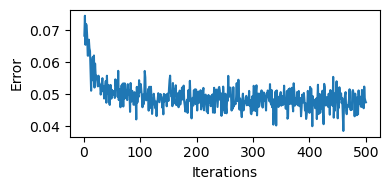

In [14]:
# Plot error
figure(figsize=(4, 2))
ylabel("Error")
xlabel("Iterations")
plot(1:num_iter, errorarr)
tight_layout()

### 重み行列 (受容野)の描画
学習後の重み行列 `Phi` ($\Phi$)を可視化してみよう。

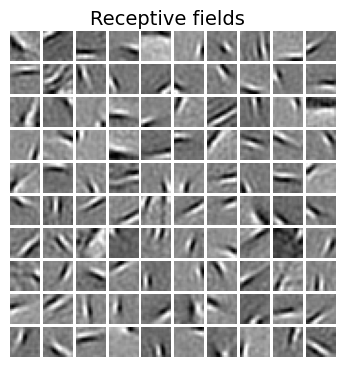

In [15]:
# Plot Receptive fields
figure(figsize=(4.2, 4))
subplots_adjust(hspace=0.1, wspace=0.1)
for i in 1:num_units
    subplot(10, 10, i)
    imshow(reshape(model.Phi[:, i], (sz, sz)), cmap="gray")
    axis("off")
end
suptitle("Receptive fields", fontsize=14)
subplots_adjust(top=0.925)

白色が**ON領域**(興奮)、黒色が**OFF領域**(抑制)を表す。Gaborフィルタ様の局所受容野が得られており、これは一次視覚野(V1)における単純型細胞(simple cells)の受容野に類似している。